In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

C:\Users\karagiag\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv("C:\Users\karagiag\Downloads\GLD.csv", parse_dates = True, index_col=0)

In [3]:
data = data.rename(columns={"Adj Close":"price"})

In [4]:
# Test for Stationarity with ADF
ts.adfuller(data['price'],1)

# i.e. Yt = ρYt−1 + ut
# Yt − Yt−1 = ρYt−1 − Yt−1 + u
# ∆Yt = (ρ − 1)Yt−1 + ut
#Let us call (ρ − 1) = δ, then ∆Yt = δYt−1 + ut
#Ho δ = 0, we have a unit root (ρ=1)/nonstationary (i.e. a random walk without a drift)
#Ha δ < 0,  this means ρ < 1 (there is no unit root and the series is stationary)

(-1.3493961757640049,
 0.60628171262702313,
 0L,
 1466L,
 {'1%': -3.4348184769200056,
  '10%': -2.5678206931092951,
  '5%': -2.86351353803652},
 5405.5251227203362)

In [5]:
#Test for stationarity using the Hurst exponent
#Thus it can be seen that if H = 0.5 we have a GBM, since it simply becomes the previous
#relation. However if H= 0.5 then we have trending or mean-reverting behaviour. 
#H < 0.5 - The time series is mean reverting
#H = 0.5 - The time series is a Geometric Brownian Motion
#H > 0.5 - The time series is trending

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
# Create the range of lag values
    lags = range(2, 100)
# Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
# Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
# Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

print("Hurst(GLD): %s" % hurst(data['price']))

Hurst(GLD): 0.451872070494


In [6]:
# Test for Cointegration of GLD & GDX
# in order to do that we find a linear combination of the two, we calculate their spread 
# i.e. residuals and examine if that is stationary with the ADF test above.
GLD = pd.read_csv('C:/Users/karagiag/Downloads/Chan/GLD.csv', index_col=0, parse_dates=True)
GDX = pd.read_csv('C:/Users/karagiag/Downloads/Chan/GDX.csv', index_col=0, parse_dates=True)

In [7]:
df = pd.DataFrame(index=GLD.index)
df['GLD']=GLD['Adj Close']
df['GDX']=GDX['Adj Close']

In [8]:
df.head()

,GLD,GDX
Date,,
2012-09-20,171.470001,52.353786
2012-09-21,171.960007,52.787186
2012-09-24,171.050003,51.005459
2012-09-25,170.770004,50.244617
2012-09-26,169.809998,50.466125


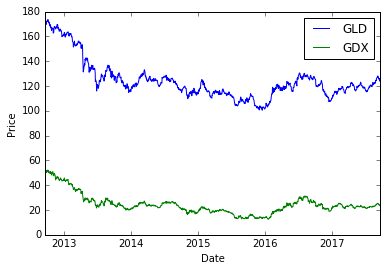

In [11]:
%matplotlib inline
fig1, ax = plt.subplots()
ax.plot(df.index,df['GLD'])
ax.plot(df.index,df['GDX'])
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()

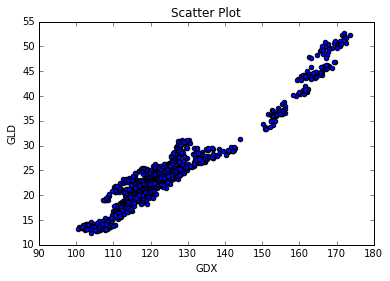

In [12]:
plt.scatter(df['GLD'], df['GDX'])
plt.ylabel('GLD')
plt.xlabel('GDX')
plt.title('Scatter Plot')

In [13]:
#Calculate hedge ratio
model = sm.OLS(df['GLD'],df['GDX'])
results = model.fit()
beta= results.params[0]
print beta

4.7894982459


In [14]:
# Calculate Residuals
df['res']= df['GLD']-beta*df['GDX']
df.head()

,GLD,GDX,res
Date,,,
2012-09-20,171.470001,52.353786,-79.278365
2012-09-21,171.960007,52.787186,-80.864128
2012-09-24,171.050003,51.005459,-73.240553
2012-09-25,170.770004,50.244617,-69.876501
2012-09-26,169.809998,50.466125,-71.897419


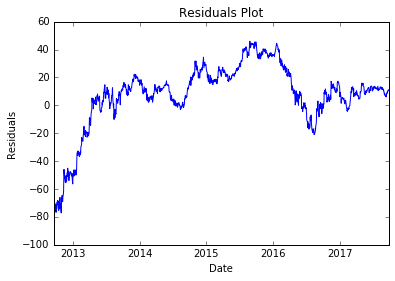

In [17]:
#Plot residuals
fig3, ax = plt.subplots()
ax.plot(df.index, df['res'])
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

In [18]:
ts.adfuller(df['res'],1)

(-3.888013090814308,
 0.0021248567569935308,
 1L,
 1256L,
 {'1%': -3.4355671297788666,
  '10%': -2.5679966213893057,
  '5%': -2.8638438984080117},
 5523.1389499733095)

In [ ]:
# Test statistic is smaller than the 1% critical value hence we can reject the Null Hypothesis
#that there is a unit root, i.e. data is nonstationary. Hence residuals are stationary(mean-rev)
# In other words GLD and GDX time-series are cointegrated.